# **Importing libraries**

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# **1.Data loading functions**

In [4]:
import gdown

In [5]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=12755faf-49ef-4c08-a459-0e9650d4ffb1
To: /content/data.zip
100%|██████████| 423M/423M [00:02<00:00, 160MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [6]:
def load_video(path:str) -> List[float]:
    """
    This function loads a video from the given path and returns a list of its frames.

    Args:
        path (str): The path to the video file.

    Returns:
        A list of the frames of the video. Each frame is represented as a float tensor of shape (height, width, 1).

    """
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [7]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [8]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}"
    f"(size= {num_to_char.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size= 40)


In [9]:
char_to_num(['s','a','b','a','r','i'])

<tf.Tensor: shape=(6,), dtype=int64, numpy=array([19,  1,  2,  1, 18,  9])>

In [10]:
num_to_char([19,  1,  2,  1, 18,  9])

<tf.Tensor: shape=(6,), dtype=string, numpy=array([b's', b'a', b'b', b'a', b'r', b'i'], dtype=object)>

In [11]:
def load_alignments(path:str) -> List[str]:
    """
    This function loads the alignments from the given path.

    Args:
        path (str): The path to the alignments file.

    Returns:
        A list of the alignment labels. Each label is represented as an integer.

    """
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [12]:
def load_data(path: str):
    """
    This function loads the data from the given path.
    The data consists of a video and its corresponding alignments.

    Args:
        path (str): The path to the data directory.

    Returns:
        A tuple containing the video frames and the alignments.

    """
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [13]:
test_path = "data/s1/bbal6n.mpg"

In [14]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [15]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [16]:
frames.shape

TensorShape([75, 46, 140, 1])

In [17]:
alignments.shape

TensorShape([21])

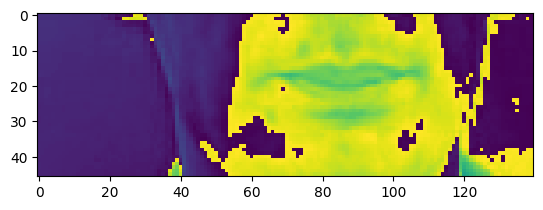

In [18]:
plt.imshow(frames[20])

In [19]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [20]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [21]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# **2.Data Pipeline**

In [22]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [23]:
frames, alignments = data.as_numpy_iterator().next()

In [24]:
len(frames)


2

In [25]:
sample = data.as_numpy_iterator()

In [26]:
val = sample.next() ; val[0]

array([[[[[ 1.4142532 ],
          [ 1.4142532 ],
          [ 1.4505161 ],
          ...,
          [ 0.32636613],
          [ 0.32636613],
          [ 0.32636613]],

         [[ 1.486779  ],
          [ 1.2692016 ],
          [ 1.3779904 ],
          ...,
          [ 0.32636613],
          [ 0.32636613],
          [ 0.32636613]],

         [[ 1.4142532 ],
          [ 1.4142532 ],
          [ 1.4142532 ],
          ...,
          [ 0.39889193],
          [ 0.29010323],
          [ 0.29010323]],

         ...,

         [[ 1.0516242 ],
          [ 1.0516242 ],
          [ 1.0516242 ],
          ...,
          [ 0.07252581],
          [ 0.07252581],
          [ 0.07252581]],

         [[ 1.0153613 ],
          [ 1.0153613 ],
          [ 1.0153613 ],
          ...,
          [ 9.24704   ],
          [ 9.24704   ],
          [ 0.0362629 ]],

         [[ 1.0153613 ],
          [ 1.0153613 ],
          [ 1.0153613 ],
          ...,
          [ 0.0362629 ],
          [ 0.0362629 ],
          

In [54]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

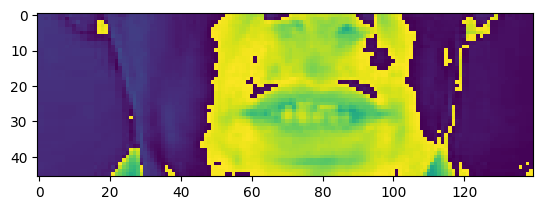

In [27]:
plt.imshow(val[0][0][27])

In [28]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay green at l nine soon'>

# **3. Deep Neural Network**

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [30]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [31]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [33]:
yhat = model.predict(val[0])

1/1 [==============================] - 5s 5s/step


In [34]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'11111111111111111111111111111111111111111111111111111111111111111111111111z'>

In [35]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'11111111111111111111111111111111111111111111111111111111111111111111111111z'>

In [36]:
model.input_shape

(None, 75, 46, 140, 1)

In [37]:
model.output_shape

(None, 75, 41)

# **4. Train**

In [42]:
def scheduler(epoch, lr):
    """
    This function creates a learning rate scheduler that decreases the learning rate by a factor of 0.1 after every 30 epochs.

    Args:
        epoch (int): The current epoch number.
        lr (float): The current learning rate.

    Returns:
        The new learning rate.

    """
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [43]:
def CTCLoss(y_true, y_pred):
    """
    Computes the CTC loss.

    Args:
        y_true: A tensor of ground truth labels of shape (batch_size, time_steps).
        y_pred: A tensor of predicted labels of shape (batch_size, time_steps, num_classes).

    Returns:
        A tensor containing the CTC loss.
    """
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [44]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        """
    This function is called at the end of each epoch.
    It prints out the original text and the predicted text for a sample of the data.

    Args:
        epoch (int): The current epoch number.
        logs (dict): A dictionary of logs with scalar values.

    Returns:
        None.

    """
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback, example_callback])

1/1 [==============================] - 2s 2s/step
Original: place blue by c seven again
Prediction: la e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red in k five again
Prediction: la e e e e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 903s 2s/step - loss: 85.5824 - val_loss: 69.1954 - lr: 1.0000e-04


# **5. Prediction with high epoch trained model**

In [38]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=84d66512-a5ff-424b-a0da-7a7db3a636e5
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 149MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [39]:
model.load_weights('models/checkpoint')

In [40]:
test_data = test.as_numpy_iterator()

In [41]:
sample = test_data.next()

In [45]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 274ms/step


In [46]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set white with sp v nine again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set red by b six please'>]

In [47]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [48]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set white with sp s nine again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set red by b six please'>]

# **6. Testing on a video**

In [49]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [50]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [51]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [52]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [53]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]